Update and install libraries

In [1]:
!git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull && cd ..

!pip install -qr vision_transformer/vit_jax/requirements.txt
!pip install -q tfds-nightly

fatal: destination path 'vision_transformer' already exists and is not an empty directory.
Already up to date.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 4.1 MB/s eta 0:00:00


In [2]:
!pip list | grep jax

jax                              0.4.13
jaxlib                           0.3.25


Import libraries in correct version


In [3]:
!pip install jax==0.3.25 jaxlib==0.3.25 flax==0.6.2 orbax-checkpoint==0.1.1

!pip list | grep jax

  Using cached jax-0.3.25-py3-none-any.whl
  Using cached flax-0.6.2-py3-none-any.whl (189 kB)
  Attempting uninstall: jax
    Found existing installation: jax 0.4.13
    Uninstalling jax-0.4.13:
      Successfully uninstalled jax-0.4.13
  Attempting uninstall: flax
    Found existing installation: flax 0.7.0
    Uninstalling flax-0.7.0:
      Successfully uninstalled flax-0.7.0
jax                              0.3.25
jaxlib                           0.3.25


In [4]:
import jax, PIL, os, jax.tools.colab_tpu, flax, numpy as np, sys, cv2, shutil, zipfile, pandas as pd, tensorflow as tf, os, tensorflow_datasets as tfds, optax, tqdm, ml_collections
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')
%load_ext autoreload
%autoreload 2
from absl import logging
from matplotlib import pyplot as plt
from vit_jax import checkpoint, input_pipeline, utils, models, train
from vit_jax.configs import common as common_config, models as models_config
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount("/content/gdrive")
%env USE_TORCH=False

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
env: USE_TORCH=False


In [5]:
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
  logging.set_verbosity(logging.INFO)
  print(jax.local_devices())
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Connected to TPU.
[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


## Download dataset

In [6]:
!cp "/content/gdrive/MyDrive/PUC/TCC/Notebooks/preTreinados/kaggle.json" "."
!chmod 600 kaggle.json
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
del zip_ref
!mv /content/HAM10000_images_part_1/*.jpg /content/HAM10000_images_part_2

rm: cannot remove '/root/.kaggle': No such file or directory
100% 5.20G/5.20G [01:21<00:00, 96.0MB/s]
100% 5.20G/5.20G [01:21<00:00, 68.3MB/s]


In [10]:
datasetMetadata = pd.read_csv("/content/HAM10000_metadata.csv")
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization']) # Non-utilized columns
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace = True)                       # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['lesionId'].apply(lambda x: False if x in uniqueLesions else True) # Fill the rows indicating if the lesion has a duplicated image

del uniqueLesions
datasetMetadata = datasetMetadata[~((datasetMetadata['lesionId'].duplicated()) & (datasetMetadata['duplicate']))]
cancerType = {
    'akiec': 0, # 0.0 - 'Doenca de Bowens'
    'bcc': 1, # 1.0 - 'Carcinoma basocelular'
    'bkl': 2, # 2.0 - 'Keratose benigna'
    'df': 3, # 3.0 - 'Dermatofibroma'
    'vasc': 4, # 4.0 - 'Lesao vascular'
    'mel': 5, # 5.0 - 'Melanoma'
    'nv': 6  # 6.0 - 'Nevo melanocitico'
}
num_classes = len(cancerType)

parentDir = './classes'
subdirectories = ['akiec', 'bcc', 'bkl', 'df', 'vasc', 'mel', 'nv']

os.makedirs(parentDir, exist_ok=True)
for subdir in ['train', 'test']:
    os.makedirs(os.path.join(parentDir, subdir), exist_ok=True)
    subdirPath = os.path.join(parentDir, subdir)
    for subsubdir in subdirectories:
        os.makedirs(os.path.join(subdirPath, subsubdir), exist_ok=True)

x = datasetMetadata[['lesionId', 'imageId']]
y = datasetMetadata['cancerId']

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size = 0.2, train_size = 0.8, stratify = y)

def sortImages(parentDir, x, y):
    for i in range(len(x)):
      """@TODO TEST"""
      imageId = x.iloc[i]['imageId']
      cancerId = y.iloc[i]
      destinationPath = ''
      if cancerId == 'akiec':
        destinationPath = os.path.join(parentDir, 'akiec/' + imageId + '.jpg')
      elif cancerId == 'bcc':
        destinationPath = os.path.join(parentDir, 'bcc/'   + imageId + '.jpg')
      elif cancerId == 'bkl':
        destinationPath = os.path.join(parentDir, 'bkl/'   + imageId + '.jpg')
      elif cancerId == 'df':
        destinationPath = os.path.join(parentDir, 'df/'    + imageId + '.jpg')
      elif cancerId == 'vasc':
        destinationPath = os.path.join(parentDir, 'vasc/'  + imageId + '.jpg')
      elif cancerId == 'mel':
        destinationPath = os.path.join(parentDir, 'mel/'   + imageId + '.jpg')
      elif cancerId == 'nv':
        destinationPath = os.path.join(parentDir, 'nv/'    + imageId + '.jpg')
      shutil.move(''.join(["/content/HAM10000_images_part_2/", imageId, '.jpg']), destinationPath)
sortImages('./classes/train', X_train, y_train)
sortImages('./classes/test', X_test, y_test)
del X_train, X_test, y_train, y_test, x, y,parentDir, subdirectories, subsubdir, subdirPath, datasetMetadata

In [6]:
batch_size = 64 # Divided by the number of cores (8)
config = common_config.get_config()
config.batch = batch_size
config.pp = ml_collections.ConfigDict(
             {'train': 'train[:80%]',
              'test': 'test',
              'crop': 224})
ds_train = input_pipeline.get_data_from_directory(config=config, directory='./classes/train', mode='train')
ds_test = input_pipeline.get_data_from_directory(config=config, directory='./classes/test', mode='test')
del config

## Import VIT model

In [7]:
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

assert os.path.exists(f'{model_name}.npz')

### Model loading

In [8]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

### Load and compile model

In [11]:
batch = next(iter(ds_train.as_numpy_iterator()))
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    batch['image'][0, :1],#next(iter(ds_train.map(lambda x, y: x).batch(1))),
    train=False,
), backend='cpu')()

In [12]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [13]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (7,)
params_repl.cls: _ShardedDeviceArray (8, 7)


In [14]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [15]:
def get_accuracy(params_repl):
  good = total = 0
  steps = 1494 // batch_size # Testset size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [16]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

  9%|▊         | 2/23 [00:38<06:45, 19.33s/it]


DeviceArray(0.03125, dtype=float32)

### Fine-tune

In [17]:
total_steps = 10
warmup_steps = 1
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [18]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [19]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 10/10 [01:35<00:00,  9.52s/it]


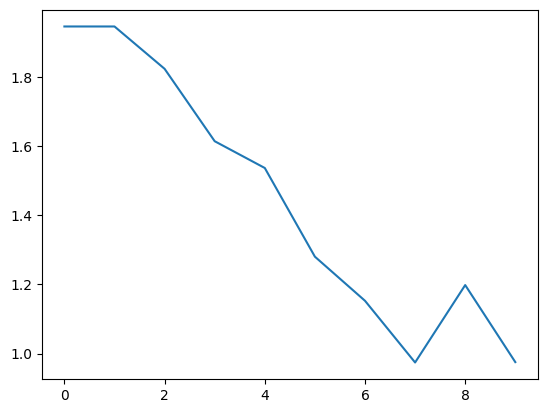

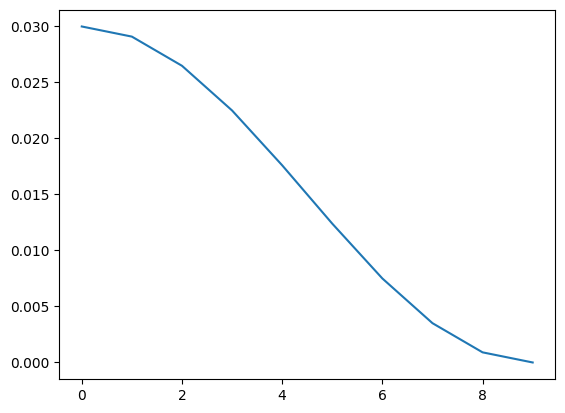

In [20]:
losses = []
lrs = []

for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [21]:
get_accuracy(params_repl)

  9%|▊         | 2/23 [00:19<03:22,  9.63s/it]


DeviceArray(0.7265625, dtype=float32)

In [24]:
import pickle

with open('/content/gdrive/MyDrive/PUC/TCC/Notebooks/preTreinados/VIT_params.pkl', 'wb') as file:
    pickle.dump(params_repl, file)

In [23]:
!cp ViT-B_32.npz /content/gdrive/MyDrive/PUC/TCC/Notebooks/preTreinados/